# **1. Base model**

In this first notebook, we are going to train a base model using a simple CNN architecture without any regularization techniques. Our goal is to create a model that will serve as a reference and which we can improve upon.

# Introduction

## CNN Architecture

A Convolutional Neural Network (CNN) is a type of deep neural network used for image recognition and classification. It consists of two parts: a feature-extraction part and a classifier. The extractive part corresponds to the convolutional network, whilst the classifier is a fully-connected dense neural network (DNN).

The main building blocks of a CNN are the convolutional layers, which consist of a series filters (also known as **kernels**) that extract features from the input images. Each filter starts at a certain position of the image and will continue to slide over it with a predetermined step-size (stride), computing the dot product between its weights (which will be adjusted during the fitting process using back-propagation) and the image below. The process of adjusting the weights of each filter involves minimizing a loss function (typically cross-entropy loss) between the prediction and the true labels in the original dataset. In order to do this, an optimization algorithm is used to update the value of the weights. Some popular optimization algorithms include Adam (which we will be using for our problem), stochastic-gradient descent (SGD) or RMSprop.

Thus, the output of each filter will be a feature map, which will then be passed through a  pooling layer before entering the next convolutional layer for further feature extraction. The pooling layers are used for performing dimensionality reduction on the feature maps, which helps make them more robust to small variations in the input images, as well as reduce the training process.

<p>
    <img src="docs/CNN.png" alt>
</p>

***Convolution and max-pooling operations in CNNs***: [J. Kim, J. Hong y H. Park, “Prospects of deep learning for medical imaging,” Precision and
Future Medicine](https://www.pfmjournal.org/journal/view.php?doi=10.23838/pfm.2018.00030)

The first layers of the CNN are typically shallow, meaning they are made up of less filters, which are wider in size. The features extracted in these layers tend to be more general, detecting edges or the general shape of the image. As we advance in the network, the number of filters increases (i.e., the layers become deeper) and the extracted features become more and more complex, referring to very detailed and specific characteristics from the image that are often uninterpretable for us humans. 

Once the image has been passed through the convolutional part of the network, the output is flattened and passed to the classifier (DNN). In this part of the architecture each neuron computes a weighted sum of the input features and applies a non-linear activation function (typically ReLU), to produce the output. The final layer is then used for classifying the image, using one neuron for each of the classes in the input problem. In this layer, the activation function is either sigmoig (for binary classification) or soft-max (for multiclass problems). 

**Sources**:

+ Y. LeCun, K. Kavukcuoglu and C. Farabet, "Convolutional networks and applications in vision," Proceedings of 2010 IEEE International Symposium on Circuits and Systems, Paris, France, 2010, pp. 253-256, doi: 10.1109/ISCAS.2010.5537907.
+ [Basic CNN architecture: Explaining 5 layers of Convolutional Neural Network (2022) upGrad blog](https://www.upgrad.com/blog/basic-cnn-architecture/#:~:text=other%20advanced%20tasks.-,What%20is%20the%20architecture%20of%20CNN%3F,the%20main%20responsibility%20for%20computation). (Accessed: April 1, 2023). 
+ [Pramoditha, R. (2022) Convolutional Neural Network (CNN) architecture explained in plain English using simple diagrams, Medium. Towards Data Science.](https://towardsdatascience.com/convolutional-neural-network-cnn-architecture-explained-in-plain-english-using-simple-diagrams-e5de17eacc8f) (Accessed: April 1, 2023). 

In [1]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves

2023-03-29 12:15:34.622348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-29 12:15:34.623320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-29 12:15:34.623329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Load data

Our data was downloaded from [kaggle](https://www.kaggle.com/datasets/sivarazadi/wikiart-art-movementsstyles). We have saved our data in a directory called `data`, which must be located within the same folder as the execution notebooks. Within `data`, we can find three separate directories: `train`, `test` and `validation`, which contain an equal number of randomly selected images from each of the art classes selected. 

To allow for code reproducibility, we provide a script called `src/data_generation.py` which will automatically create the required directory structure. We recommend executing this code from the project folder.

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also check how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Renaissance', 'Realism', 'Baroque', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Renaissance   4000         500   500
Realism       4000         500   500
Baroque       4000         500   500
Romanticism   4000         500   500


We can see that all classes are well balanced, and that we have a fair amount of data for training and validation.

It is also important to create the directory where the models will be saved. We only need to do this once, since the rest of the notebooks will use this same directory for saving their respective models.

In [6]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

# 1.1. Model structure

Let's first create the model structure. We will start by defining the values of some hyperparameters:

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (256, 256,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


We can now define the structure of the model:

In [8]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
         )
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly [how many parameters](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d) it has in order to have a better idea of how flexible this model is:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

We have a total of approximately 13 million parameters to train in our network.

### Adam optimizer

Adam (Adaptive Moment Estimation) optimizer is a popular and versatile optimization algorithm. It works as an extension of stochastic gradient descent (SGD) that uses adaptive learning rates to find the optimal value for each parameter by combining the estimate of the mean (first moment) and variance (second moment) of the gradients, which are updated at each iteration of the training process. It also includes to ensure accurate estimation of the moments. Once the estimates are calculated, it then updates the parameters by adding the learning rate to the current parameter value. The learning rate for each parameter is normally scaled by a factor called the `decay rate`, which controls the rate at which the learning rate decreases over time.

**Sources**
+ Kingma, D. P., & Ba, J. (2017). [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) - arXiv preprint arXiv:1412.6980.
+ [Doshi, S. (2020) Various optimization algorithms for training neural network, Medium. Towards Data Science](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6) (Accessed: April 1, 2023). 
+ [Brownlee, J. (2021) Gentle introduction to the adam optimization algorithm for deep learning, MachineLearningMastery.com.](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) (Accessed: April 1, 2023). 

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

# 1.2. Data preprocessing

A critical step when creating these kind of models is how the input data is preprocessed. This includes:

* **Normalize the input** by dividing each pixel by its maximum value (i.e, 255).
* Define the **input shape**, which affects to the final model (for instance, the number of parameters it has, and therefore its complexity).
* **Batch size**: this is the number of images in each batch. It should not be too small, since it may affect the convergence of the model, but it should not be too large either, since it will increase the time it takes to update the parameters of the model.

In [11]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128, 4)


We can appreciate that the batches indeed have the shape we are looking for, with 128 images belonging 4 classes and having 256 by 256 pixels, using 3 channels (as we are dealing with color images).

# 1.3. Training

Let's train the model:

We use `EarlyStopping` to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e.: we will stop after there is no improvement in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs (in this case we chose 30), as we can be fairly sure that training will be stopped before reaching the limit.

**Sources**:

+ [Brownlee, J. (2020) Use early stopping to halt the training of neural networks at the Right Time, MachineLearningMastery.com](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) (Accessed: April 1, 2023). 

In [13]:
# Model name and path
model_path = os.path.join("models", "base_model.h5")

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
118/125 [===========================>..] - ETA: 16s - loss: 1.2377 - acc: 0.4427

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.2328 - acc: 0.4460
Epoch 1: val_loss improved from inf to 1.20296, saving model to models/base_model.h5
125/125 [==============================] - 329s 3s/step - loss: 1.2328 - acc: 0.4460 - val_loss: 1.2030 - val_acc: 0.4742
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.1017 - acc: 0.5288
Epoch 2: val_loss improved from 1.20296 to 1.03455, saving model to models/base_model.h5
125/125 [==============================] - 320s 3s/step - loss: 1.1017 - acc: 0.5288 - val_loss: 1.0345 - val_acc: 0.5961
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.0294 - acc: 0.5608
Epoch 3: val_loss improved from 1.03455 to 0.98551, saving model to models/base_model.h5
125/125 [==============================] - 319s 3s/step - loss: 1.0294 - acc: 0.5608 - val_loss: 0.9855 - val_acc: 0.6320
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 0.9855 - acc: 0.5829
Epoch 4: val_loss 

As was expected, training was cut after reaching 13 epochs, which means validation accuracy did not significantly improve after epoch 8, although training validation did. This means that after the last checkpoint the model was just overfitting to the data without any significant gain upon performance on unseen data.

We can load the best model found during training using the following code:

In [17]:
# load the saved model
base_model = load_model(model_path)

# 1.4. Validation
Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

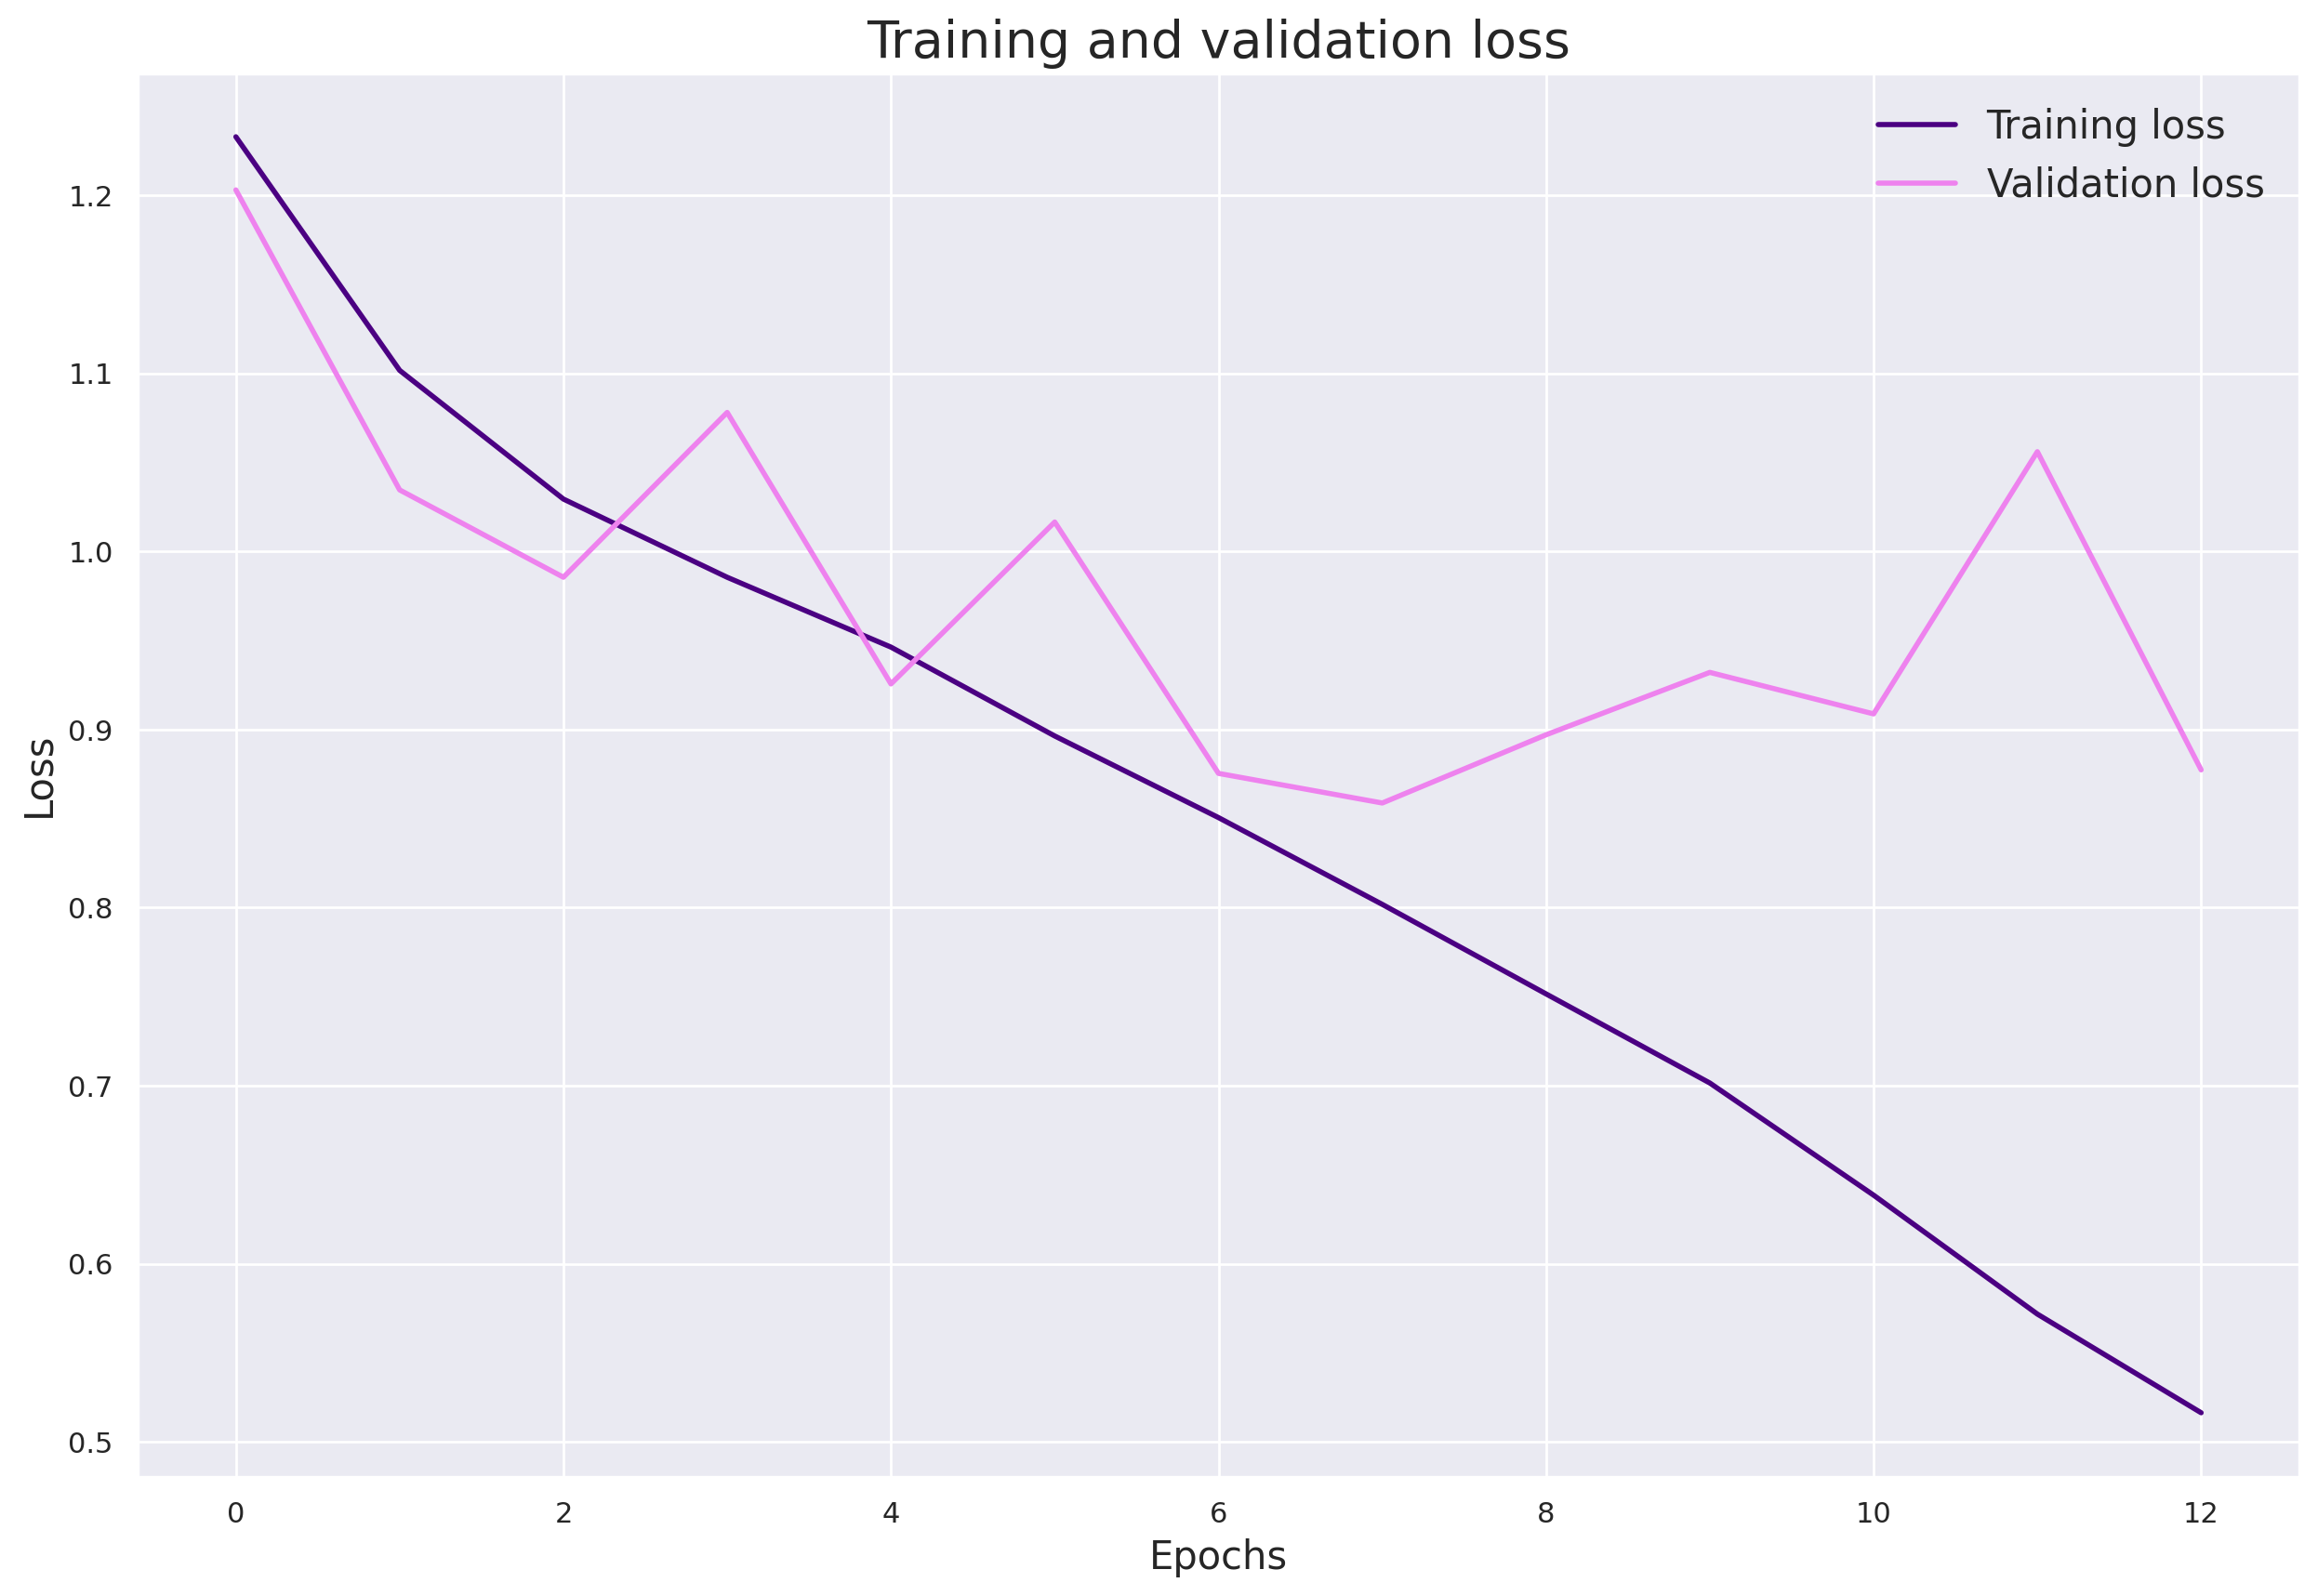

In [19]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "indigo", "violet", "Loss")

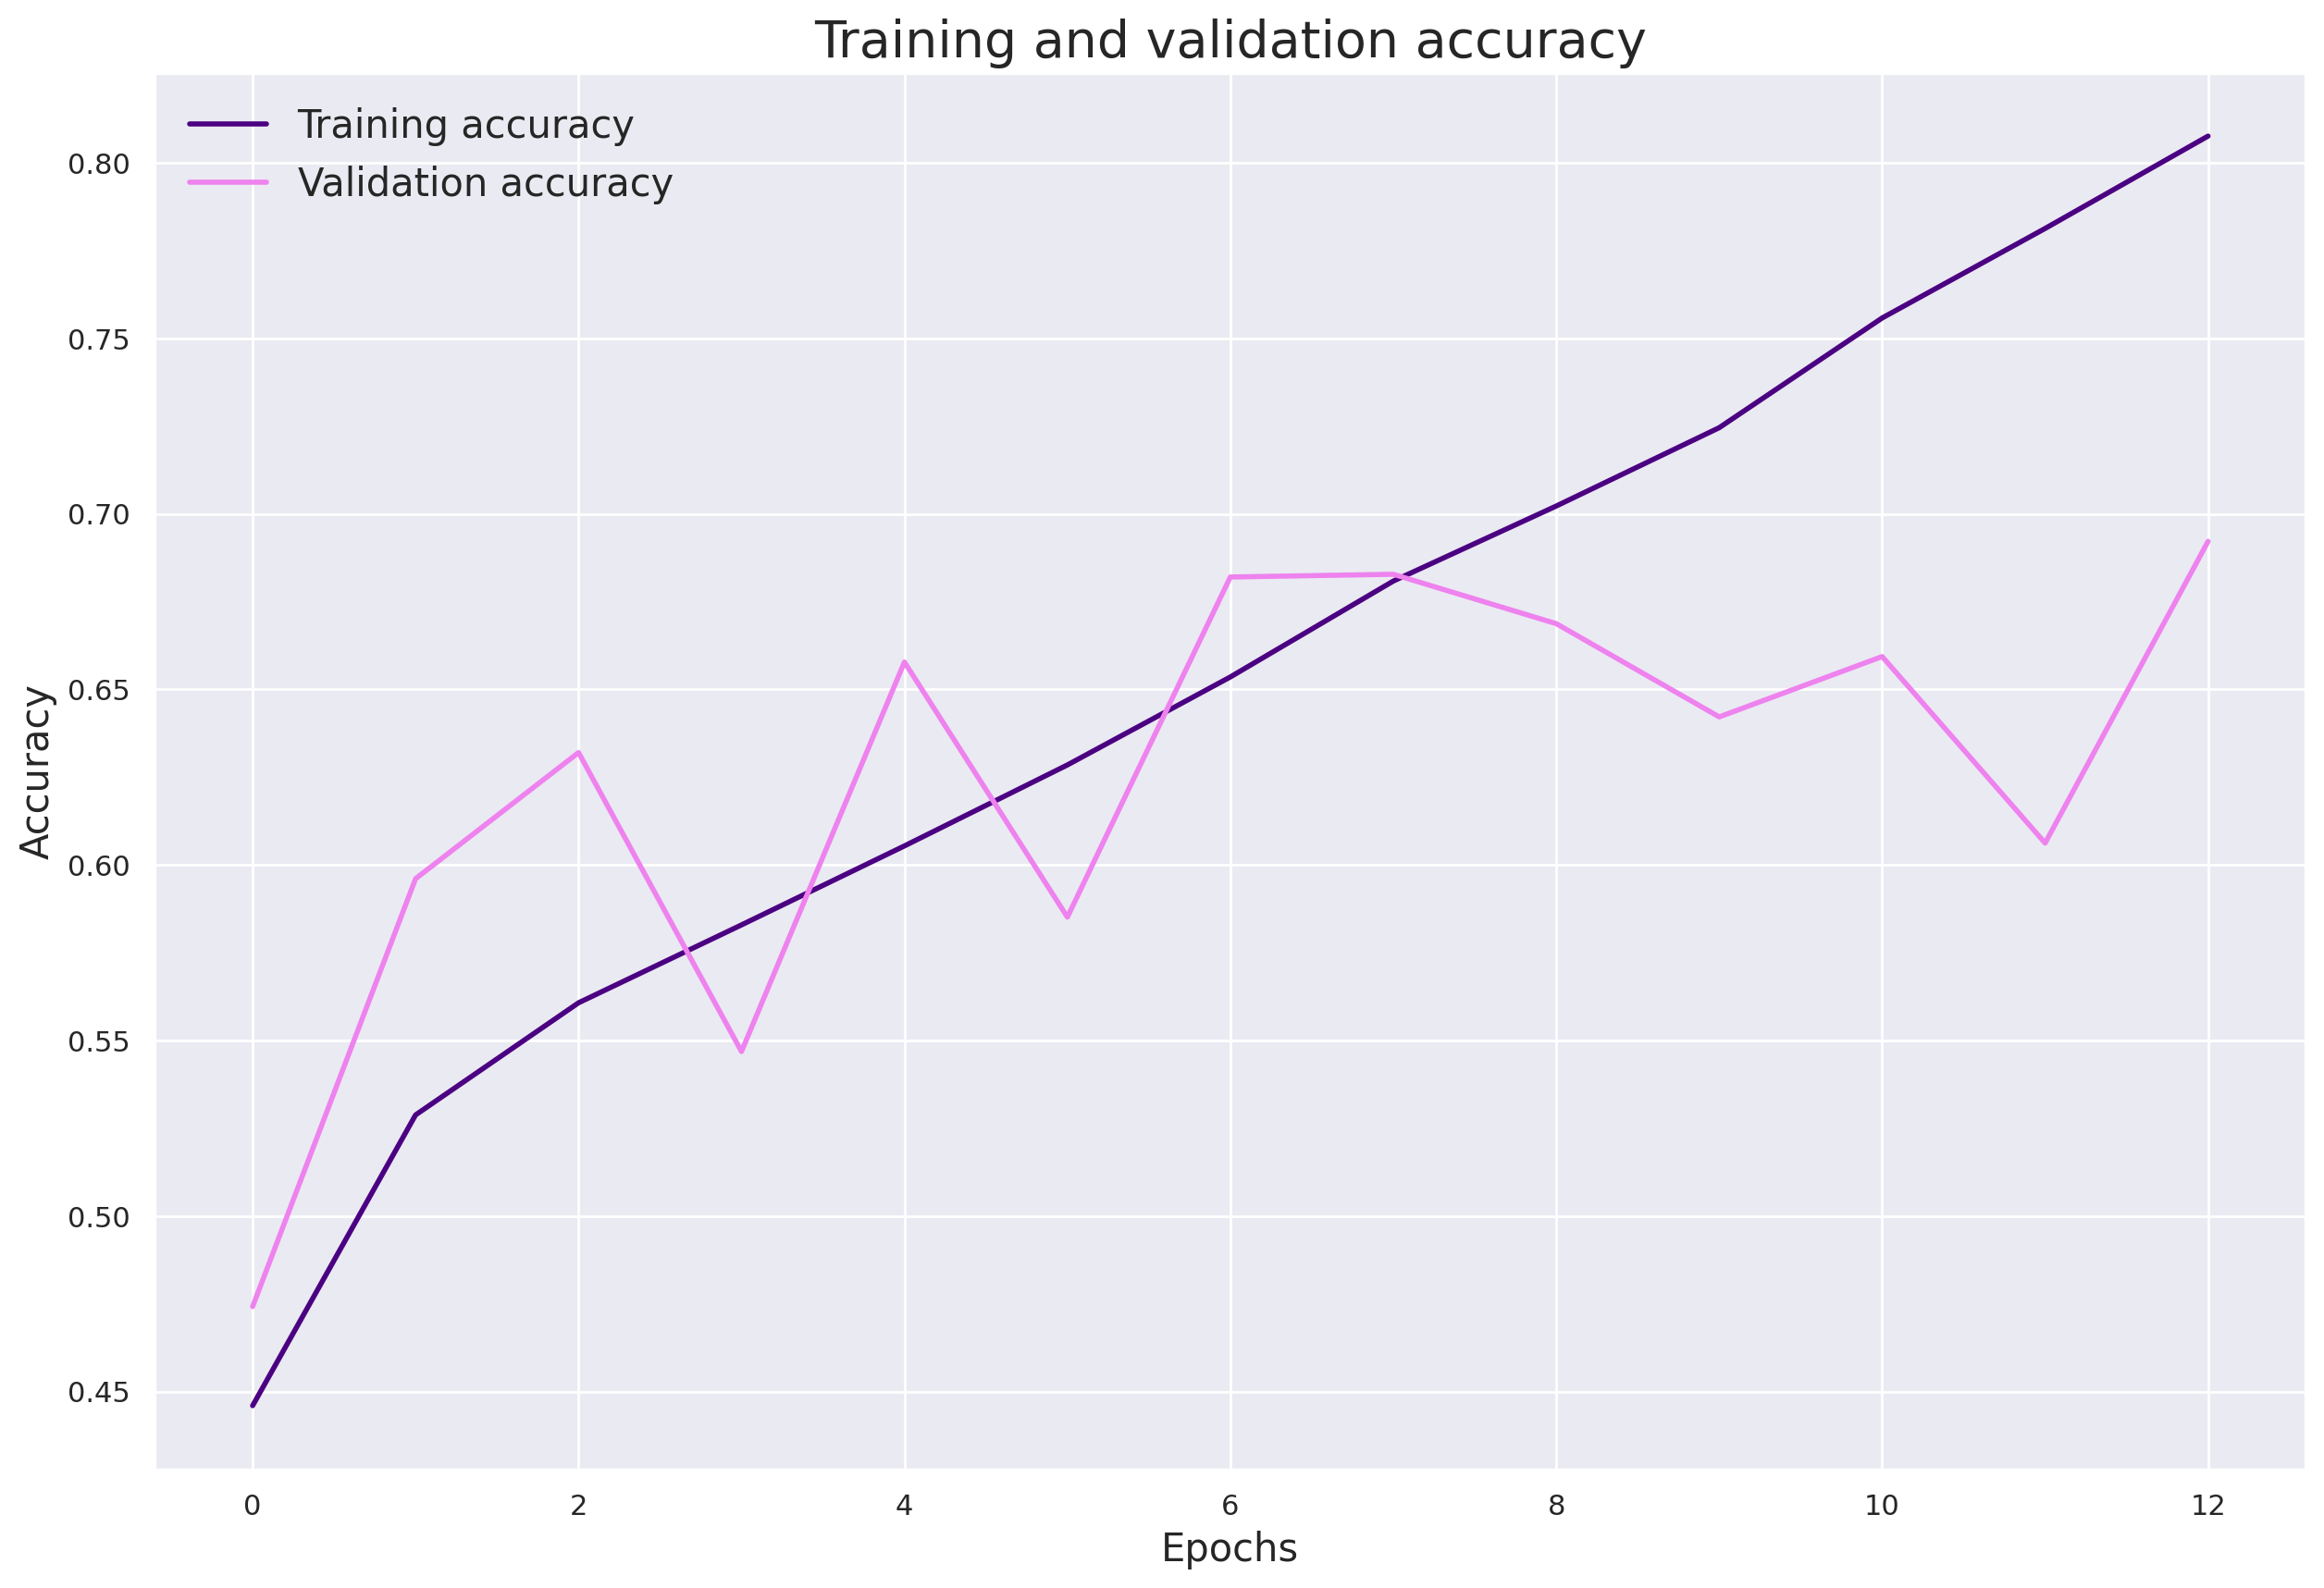

In [20]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "indigo", "violet", "Accuracy")

The above plots help us visualize more clearly why early stopping decided to cut training after 13 epochs. We can observe that after training epoch 3 validation accuracy plateaus and no significant improvement is made. Similarly, validation loss function stops decreasing from this point on, while training loss keeps on decreasing at a fast pace, which indicated that the model keeps getting better at predicting training data, but without any impact on validation accuracy. It is also interesting to see how validation loss keeps spiking during the training process, without showing a stable decrease. 

We can also see that although the model reaches an accuracy of above 80% in the training dataset, the same cannot be said for the testing dataset, where accuracy is barely reaching 60%. This means that there are clear signs of **overfitting** to the data in the model, which call for the need for implementing regularization techniques such as **dropout**, **batch normalization** and **data augmentation**, which we will be covering in the following notebooks.

In [21]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
        )

Found 2000 images belonging to 4 classes.


In [22]:
base_model.evaluate(test_generator)

50/50 [==============================] - 37s 723ms/step - loss: 1.0528 - acc: 0.6050


[1.0527710914611816, 0.6050000190734863]

When evaluating performance on the separated test dataset we can see that accuracy can only reach 60%, far less than what was observed for the training dataset. In the next notebooks we will implement different techniques to reduce the overfitting of the model and hopefully improve results in external validation. 